# Merging classification results

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import evaluate
import merge
import load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load evaluation data
test_columns = ['returnQuantity', 'articleID', 'productGroup', 'customerID', 'voucherID']
test_predictions = merge.merged_predictions(test=True, keep_columns=test_columns)
test_train = evaluate.test_complement(test_predictions)

# Load classification data
class_columns = ['articleID', 'productGroup', 'customerID', 'voucherID']
class_predictions = merge.merged_predictions(keep_columns=class_columns)
class_train = load.orders_train()

## Highest possible precision
We are interested in finding out how different our classifiers are specialised. Therefore, a possible measure is to take a look at the highest possible precision. In particular we want to find out how good we can perform if it was possible to always pick the correct prediction, if at least one group has predicted so.

In [27]:
preds = test_predictions.prediction
labels = test_predictions.original.returnQuantity
optimum = len(preds[(preds.A == labels) | (preds.B == labels) | (preds.C == labels)]) / len(preds)
disagreement = len(preds[(preds.A != preds.B) | (preds.A != preds.C)]) / len(preds)
optimum, disagreement

(0.7637576901698585, 0.21270896764621353)

It turns out that $0.763757$ is the highest reachable value knowing the prediction labels. This initially shows that we have a chance to improve predictions in comparison to every single result. On the other hand it has to be determined how many of the rows which have been classified differntly were actually guessing. The three results disagree in around 21% of the rows giving room for optimization.

## Confidences
### Imputation

Approximately 4% of predictions by team C have unknown confidences, making imputation necessary before merge approaches based on confidence can be applied. Because of this relatively small number, I propose to impute missing values using the mean confidence of Team C. The mean showed stable behavior across all splits in the test and prediction data.

### Comparison
Using approaches based on confidence implies comparison across classifiers. This is complicated by the different distributions of confidence, as depicted in the figure below.

In [4]:
# Violinplot for class data and evaluation data
def confidence_plot(class_data, evaluation_data):  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ax1.set_title('Classification')
    ax = sns.violinplot(data=class_data['confidence'], ax=ax1)
    ax2.set_title('Evaluation')
    ax = sns.violinplot(data=evaluation_data['confidence'], ax=ax2)

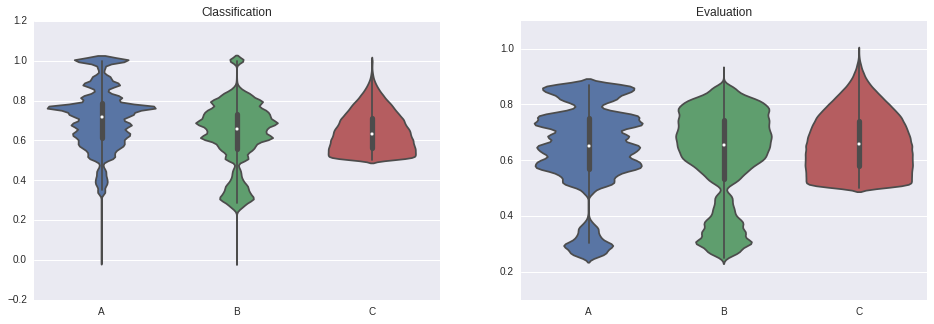

In [5]:
# Violinplot for original data
confidence_plot(class_predictions, test_predictions)

Instead of using the actual values, I propose to redefine the confidence in standard-deviations distance from the mean.

$$ conf_{i,c} = 1 + \frac{conf_{i,c} - \mu_c}{\sigma_c} * \frac{1}{max(conf_c)}$$

with $conf_{i,c}$ being the confidence of classification $c$ in row $i$. To confine the range in [-1, 1], the confidences for each classifier are divided by its maximum confidence. The center of the distributions is then moved to 1, making the confidences applicable as multiplier weights. NaN values are filled with ones (then representing the mean).

This approach centers the central tendencies at 1 and decreases the differences in the ranges by setting the standard deviations to 1.

The figure below shows the distributions of the imputed predictions.

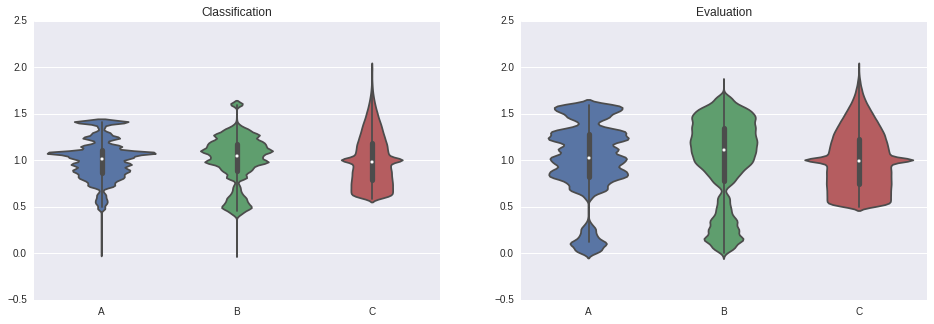

In [6]:
# Impute zeroes and convert confidenes to std-distances
class_imputed = merge.impute_confidence(class_predictions)
test_imputed = merge.impute_confidence(test_predictions)

# Violinplot for imputed data
confidence_plot(class_imputed, test_imputed)

## Approach 1: Naive Majority Vote
For each row, take the most common prediction. As we have 3 teams there is always a majority.

The naive majority vote assumes that each classifier is equally good and always equally confident. It uses relies on the least assumptions about performance evaluation and confidence comparability.

In [7]:
class_naive = merge.naive_majority_vote(class_imputed)
test_naive = merge.naive_majority_vote(test_imputed)

This approach can be evaluated on the test set; the result is shown in the figure below.

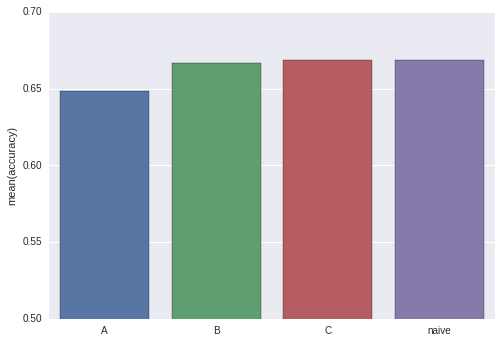

In [9]:
# Calculate mean accuracies
naive_mean_accuracies = evaluate.mean_accuracies(test_naive)

# Barplot
ax = sns.barplot(x=naive_mean_accuracies.index, y=naive_mean_accuracies['accuracy'])
lim = ax.set_ylim([0.5, 0.7])

The values are 64.85%, 66.66%, 66.86% and 66.89% in that order. The approach seems to yield a very small improvement compared to the best performing single team classification.

However, the new classification seems to resolve most of the arguments between the teams (cf. figure below). The naive merge seems to agree with teams A and C (under 1% distinct rows), while disagreeing mostly with team B (11%).

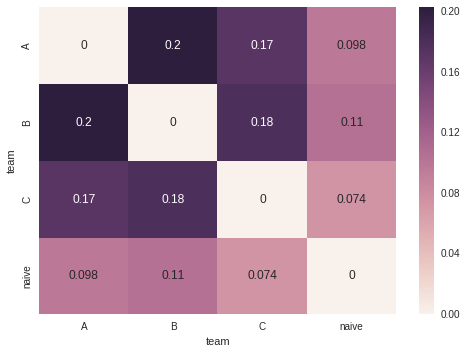

In [10]:
# Calculate difference for each combination
naive_differences = evaluate.distinct_predictions(class_naive)

# Heatmap
ax = sns.heatmap(naive_differences, annot=True)

The differences between the naive merge and team B go along with the differences team B had with other teams, the top four splits not present in the test set.

In [12]:
# Calculate differences across splits
naive_differences = evaluate.distinct_split_predictions(class_train, class_naive)

# Heatmap
ax = sns.heatmap(naive_differences, annot=True)

OSError: File b'data/splits.csv' does not exist

## Approach 2: Weighted Majority Vote

We use the following formula for the final $prediction_i$, with $i$ being the row index. In it, each $prediction_{c,i}$ of classifier $c$ is weighted.

$$
row_i =
\dfrac
    {\sum_{c \in C}
        prediction_{c,i}
        \cdot weight_{c,i}}
    {\sum_{c \in C} weight_{c,i}}
$$

The $weight_{c,i}$ takes into account the condfidence of $c$ in row $i$, the mean confidence of $c$ over all rows, the overall accuracy of $c$ and the mean accuracy of all classifiers.

$$
weight_{c,i} = \dfrac{confidence_{c,i}}{confidence_{c,\varnothing}} \cdot \bigg(\dfrac{accuracy_c}{accuracy_\varnothing}\bigg)^2
$$

The confidences returned by the classifiers are, as such, not comparable to each other. They differ in meaning and in range. To counteract and to avoid favoring classifiers that are generally -maybe mistakenly- confident, we take the confidence compared to the classifier's mean confidence.

The accuracy, we believe, is the best predictor of a classifier's performance in the target set. We take this information from a test set that each group used to evaluate their classifier. The test set is a 70/30 split of the training data. We compare the accuracy to the mean accuracy of all classifiers. As the difference tends to be big in information, but small in extent, the ratio is squared.

In [13]:
df = class_imputed.copy()

In [14]:
df[['prediction', 'confidence']].ix[5:10]

prediction              confidence  \
                                               A     B      C          A   
orderID  articleID colorCode sizeCode                                      
a1744179 i1001147  1001      42             True  True  False   0.899279   
         i1001151  3082      42             True  True  False   0.886893   
         i1001160  1108      42             True  True   True   0.609405   
         i1001461  2493      42             True  True  False   0.609405   
         i1001480  1001      42             True  True  False   0.609405   

                                                           
                                              B         C  
orderID  articleID colorCode sizeCode                      
a1744179 i1001147  1001      42        0.427345  0.858307  
         i1001151  3082      42        0.538328  0.951594  
         i1001160  1108      42        0.491853  0.817023  
         i1001461  2493      42        0.504776  0.756678  
         i1001480  1001      42        0.511578  0.656294

In [15]:
df[['prediction', 'confidence']].ix[5:10].apply(lambda d: d['prediction'] * d['confidence'], axis=1)

A         B         C
orderID  articleID colorCode sizeCode                              
a1744179 i1001147  1001      42        0.899279  0.427345  0.000000
         i1001151  3082      42        0.886893  0.538328  0.000000
         i1001160  1108      42        0.609405  0.491853  0.817023
         i1001461  2493      42        0.609405  0.504776  0.000000
         i1001480  1001      42        0.609405  0.511578  0.000000

In [18]:
weights = pd.Series([1,1,1], index=class_imputed['prediction'].columns)
merge.weighted_majority_vote(class_imputed.ix[:20], weights, rounded=True)

orderID   articleID  colorCode  sizeCode
a1744178  i1002632   3097       I           False
          i1003278   1097       40          False
          i1003279   1114       40          False
                     1116       40          False
                     1117       40          False
a1744179  i1001147   1001       42           True
          i1001151   3082       42           True
          i1001160   1108       42           True
          i1001461   2493       42           True
          i1001480   1001       42           True
          i1003229   2112       42          False
a1744180  i1000477   1001       38           True
                                40           True
                     1092       38           True
                                40           True
                     1093       38           True
                                40           True
          i1002579   1101       A            True
          i1002580   1093       I            True
         

In [19]:
weights = pd.Series([1,1,1], index=class_imputed['prediction'].columns)
test_weighted_confidence = merge.weighted_majority_vote(test_imputed, weights)
class_weighted_confidence = merge.weighted_majority_vote(class_imputed, weights)

KeyboardInterrupt: 

In [ ]:
weights = pd.Series([1,1,1], index=class_imputed['prediction'].columns)


In [ ]:
weights = evaluate.mean_accuracies(test_predictions)['accuracy']
weights
# test_weighted_confidence = merge.weighted_majority_vote(class_imputed.ix[:20], weights)

## Approach 3: Avoiding disagreement

In [ ]:
### Approach 4: Weighted Majority Vote based on plits

## Approach 4: Boost results using another classifier
Due to lack of comparability between confidence values and the probably problematic imputation of confidence values it might be interesting to follow the approach of Boosting. This means we look at the results the respective classifiers gave and try to vote always for the best in a given case. Imposing this as a machine learning problem we have as feature vector
$\boldsymbol{f}_k=(pred_k^A, pred_k^B, prediction_k^C, conf_k^A, conf_k^B, conf_k^C, art_k, cust_k, voucher_k, prod_k)$ while the last four arguments are binary and tell us if the respective category is known before evaluation. Further as target we have again class labels which refer binarily to *returned* or *not returned*. Thus, we have $y=returned, y \in \{0,1\}$ as possible labels.

We already know from section **Highest possible precision** that in around 21% of the rows we find disagreement. All other rows are not interesting for this problem and we won't touch them or learn anything from them.

### The best classifier when one disagrees
Is there one result which we can always use to resolve disagreement? We have to look at different performances when classifiers disagree.

In [38]:
agree_mask = ((test_predictions.prediction.A == test_predictions.prediction.B) & 
              (test_predictions.prediction.A == test_predictions.prediction.C))
baseline = merge.precision(test_predictions.original.returnQuantity[agree_mask],
                           test_predictions.prediction.B[agree_mask])
baseline_weight = len(preds[agree_mask])
baseline

0.69993014003494847

If classifiers agree, the precision is near 70% which is extremely good in comparison to single results. This shows that the 21% disagreement make a huge difference in classification error.

In [40]:
disagree_mask = ((test_predictions.prediction.A != test_predictions.prediction.B) | 
                 (test_predictions.prediction.A != test_predictions.prediction.C))
y_labels = test_predictions.original.returnQuantity[disagree_mask]

#### A, B, C on disagreement (baseline for boosting on disagreed rows)

In [44]:
a = merge.precision(y_labels, test_predictions.prediction.A[disagree_mask])
b = merge.precision(y_labels, test_predictions.prediction.B[disagree_mask])
c = merge.precision(y_labels, test_predictions.prediction.C[disagree_mask])
a, b, c

(0.45814186362326992, 0.54310640457606896, 0.55259187116774799)

### Accuracy using an unoptimized Decision Tree

In [84]:
from sklearn import preprocessing
from sklearn import svm
from sklearn import grid_search
from sklearn import pipeline
from sklearn import tree
from sklearn import metrics

In [55]:
categories = ['articleID', 'productGroup', 'customerID', 'voucherID']
X, y = merge.boosting_features(test_train, test_imputed, categories)

In [71]:
steps = [('scaling', preprocessing.StandardScaler()),
         ('svm', svm.SVC())]
clf = pipeline.Pipeline(steps)

In [77]:
svc_params = dict(svm__C=[0.1, 0.5, 1.0, 5.0, 100.0],
                  svm__kernel=['rbf', 'poly', 'rbf', 'sigmoid'],
                  svm__gamma=[0.1, 0.25, 0.01, 0.5],
                  svm__degree=[1, 2, 3, 4],
                  svm__coef0=[0.0, 0.1, 0.5, 1.0])
gs = grid_search.RandomizedSearchCV(clf, svc_params, n_jobs=-1, n_iter=10)
gs.fit(X, y)
gs.predict(X)

In [ ]:
clfT = tree.DecisionTreeClassifier()
tree_params = dict(criterion=['gini', 'entropy'], max_features=[2, 4, 6, 8, 10], 
                   max_depth=[2, 4, 8, 12, 16], min_samples_split=[2, 4, 6, 8, 10, 20, 30, 100],
                   min_samples_leaf=[1, 2, 4, 8, 16, 32, 100])
gsT = grid_search.RandomizedSearchCV(clf, tree_params, n_jobs=-1, n_iter=5, scoring=metrics.accuracy_score)
gs.fit(X[:5000], y[:5000])
gs.score(X, y)